### Let's go on a tour of the StyleGAN latent space.

In [1]:
import cv2
import random
import pandas as pd
import statistics

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Taken from pretrained_example.py
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

# Off-the-shelf recognizer
import face_recognition

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw, ImageFont

W0211 14:34:42.457101 140688233822016 deprecation_wrapper.py:119] From /home/ptinsley/stylegan_tour/dnnlib/tflib/tfutil.py:34: The name tf.Dimension is deprecated. Please use tf.compat.v1.Dimension instead.

W0211 14:34:42.461102 140688233822016 deprecation_wrapper.py:119] From /home/ptinsley/stylegan_tour/dnnlib/tflib/tfutil.py:74: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0211 14:34:42.462198 140688233822016 deprecation_wrapper.py:119] From /home/ptinsley/stylegan_tour/dnnlib/tflib/tfutil.py:128: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [4]:
# Plot latent vectors of shape 18x512
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((1024, 1024))

In [9]:
def setup():
    tflib.init_tf()
    # Load pre-trained network.
#     with open('./model.pkl', 'rb') as f:
#         _G, _D, Gs = pickle.load(f)
    url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
    with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
        _G, _D, Gs = pickle.load(f)
    generator = Generator(Gs, batch_size=1, randomize_noise=False) # -- RUNNING >1 TIMES THROWS ERROR
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    return [_G, _D, Gs, generator, fmt]

In [10]:
# Only run once.
[_G, _D, Gs, generator, fmt] = setup()

KeyError: "The name 'G_synthesis_1/_Run/concat:0' refers to a Tensor which does not exist. The operation, 'G_synthesis_1/_Run/concat', does not exist in the graph."

In [6]:
# Load in latent vectors
# vec1 = np.load('latent_representations/04229d87_01.npy')
# vec2 = np.load('latent_representations/04551d40_01.npy')
# vec = np.load('latent_representations/walter_scheirer_01.npy')
# vec4 = np.load('latent_representations/arnold_schwarzenegger_01.npy')

In [7]:
img1 = generate_image(vec1)

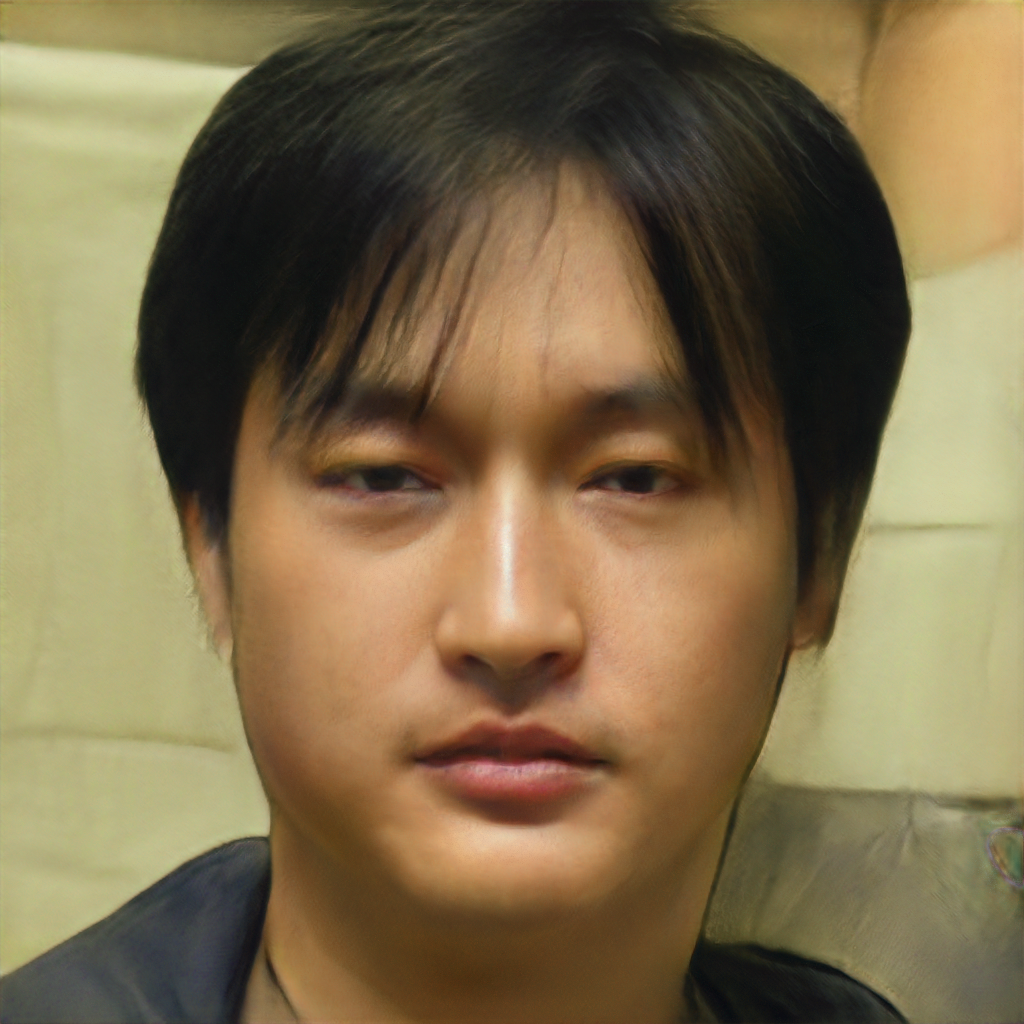

In [8]:
img1

In [9]:
img2 = generate_image(vec2)

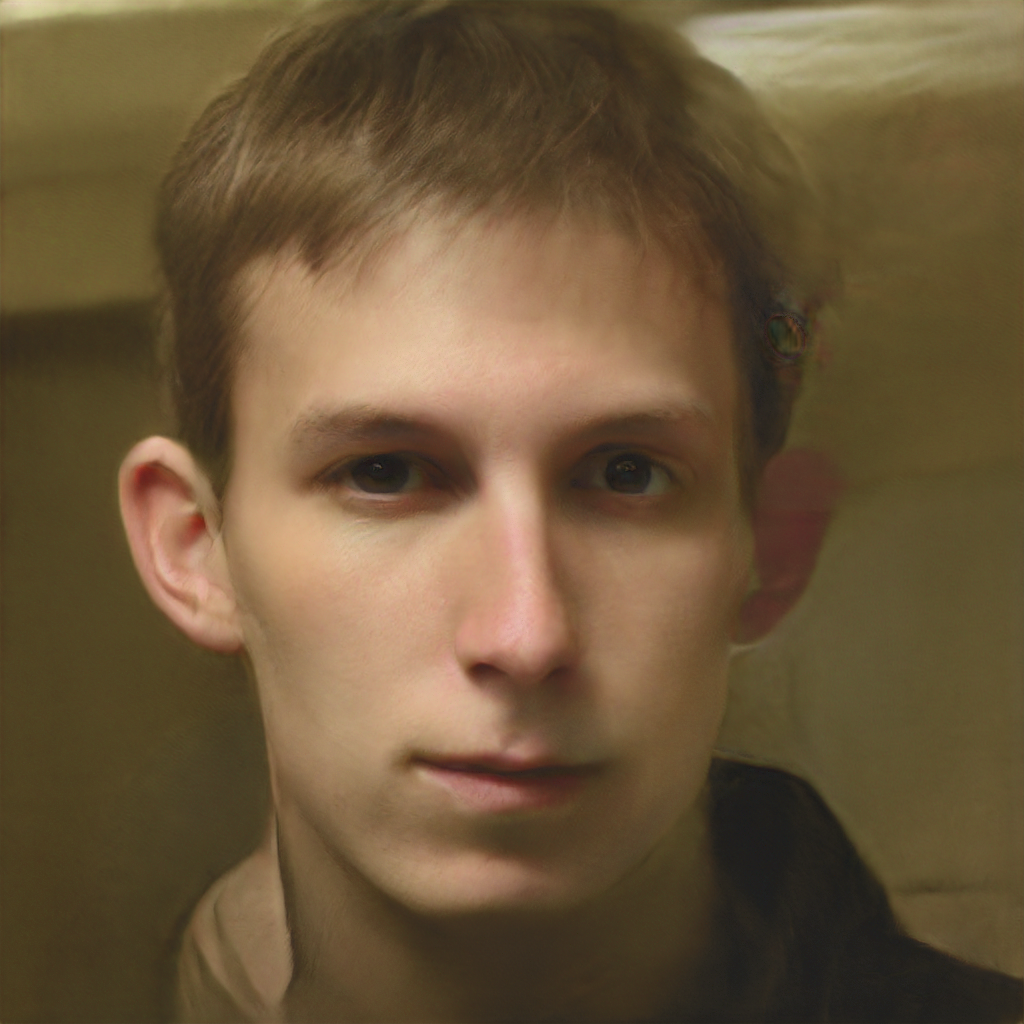

In [10]:
img2

In [ ]:
def interpolate(img1, img2, steps):    

    
    
    ### help ### 
    ### https://gist.github.com/matpalm/23dc5804c6d673b800093d0d15e5de0e (author: mat kelcey) ###

    lat_vec1_slim = np.reshape(lat_vec1, [1, lat_vec1.shape[0] * lat_vec1.shape[1]])
    lat_vec2_slim = np.reshape(lat_vec2, [1, lat_vec2.shape[0] * lat_vec2.shape[1]])

    assert(lat_vec1_slim.shape == lat_vec2_slim.shape, 'Latent vectors have different shape.')

    z = np.empty((steps, lat_vec1_slim.shape[1]))   
    for i, alpha in enumerate(np.linspace(start=1.0, stop=0.0, num=steps)):
        z[i] = alpha * lat_vec1_slim + (1.0-alpha) * lat_vec2_slim
 
    ### end help ###

#     images = []
#     for i in range(steps):
#         curr_vec = np.reshape(z[i], [18, 512]) # back to original shape
#         curr_img = generate_image(curr_vec)
#         images.append(np.array(curr_img))
        
#     s = images[0].shape
#     videowriter =  cv2.VideoWriter(fname, cv2.VideoWriter_fourcc(*'mp4v'), steps/10, (s[1], s[0]))
#     for i in range(len(images)):
#         videowriter.write(images[i][...,::-1])
#     videowriter.release()

In [6]:
# vec.shape

In [10]:
def mc_perturb(base_vector, axis, pkl_fname, magnitudes=[0.05, 0.1, 0.5, 1, 5]):
    
    # Get base image.
    base_image = generate_image(base_vector)
    
    # Get base image fr encoding.
    base_image_encoding = face_recognition.face_encodings(np.array(base_image))[0]

    # Copy base vector.
    new_vector = np.copy(base_vector)

    return_dict = {}
    return_dict['base_vector'] = base_vector
    return_dict['axis'] = axis
    return_dict['magnitudes'] = magnitudes
    
    # Loop over magnitudes.
    for magnitude in magnitudes:

        return_dict[str(magnitude)] = {}

        # images = []
        sg_distances = []
        fr_distances = []
        
        # Loop over random seeds.
        for i in range(100):
            
            print(i)
            
            # Assign random state.
            rnd = np.random.RandomState(i)
            
            # Perturb specified axis in new vector.
            new_vector[axis] = new_vector[axis] + magnitude * rnd.randn(Gs.input_shape[1])

            # Save distance in SG space.
            sg_distances.append(np.linalg.norm(base_vector-new_vector))
            
            # Get new image.
            new_image = generate_image(new_vector)
            
            # # Save image for later.
            # images.append(new_image)
            
            # Get new image fr encoding.
            new_image_encodings = face_recognition.face_encodings(np.array(new_image))

            # FACE DETECTED/ENCODED
            if len(new_image_encodings) > 0:
                new_image_encoding = new_image_encodings[0]
                fr_distance = face_recognition.face_distance([base_image_encoding], new_image_encoding)[0]

            # NO FACE DETECTED
            else:
                fr_distance = 1.0

            # Save distance in FR space.
            fr_distances.append(fr_distance)
    
        # return_dict[str(magnitude)]['images'] = images
        return_dict[str(magnitude)]['sg_distances'] = sg_distances
        return_dict[str(magnitude)]['fr_distances'] = fr_distances        
    
    with open(pkl_fname, 'wb') as f:
        pickle.dump(return_dict, f)
    
#     return return_dict

In [11]:
vec = np.load('latent_representations/kevin_bowyer_01.npy')

In [12]:
mc_perturb(vec, axis=0, pkl_fname='test.pickle', magnitudes=[1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
dirnames = os.listdir('../data/FRGC/FRGC-2.0-dist/nd1/custom_100/')

In [ ]:
len(dirnames)

In [ ]:
# dirnames[0:5]

In [ ]:
for dirname in dirnames:
    vec = np.load('../data/FRGC/FRGC-2.0-dist/nd1/custom_100/' + dirname + '/' + dirname + '_01.npy')
    for a in range(18):
        pkl_fname2 = '../data/FRGC/FRGC-2.0-dist/nd1/custom_100/' + dirname + '/' + dirname + '_axis' + str(a) + '.pkl'
        if not os.path.exists(pkl_fname2):
            print('mc_perturb-ing to create '+pkl_fname2)
            mc_perturb(vec, axis=a, pkl_fname=pkl_fname2)
        else:
            print(pkl_fname2 + ' already exists')